In [1]:
%pip install shap

Note: you may need to restart the kernel to use updated packages.


Accuracy: 0.5919

Classification report:
               precision    recall  f1-score   support

        High       0.60      0.74      0.66     20026
         Low       0.64      0.69      0.67     31182
      Medium       0.49      0.33      0.39     23975

    accuracy                           0.59     75183
   macro avg       0.57      0.59      0.57     75183
weighted avg       0.58      0.59      0.58     75183



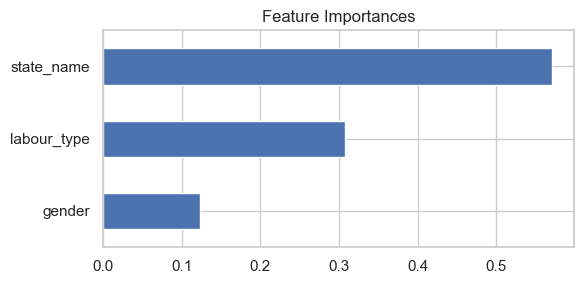

Saved feature importances to rf_feature_importances_simple.png


In [3]:
# simple_random_forest.py
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score
import matplotlib.pyplot as plt

# ----- CONFIG -----
FILE = "cleaned_agri_wages.csv"   # path to your cleaned file
FEATURES = ["state_name", "labour_type", "gender"]  # small set for simplicity
TARGET_WAGE = "monthly_average_wage"
RANDOM_STATE = 42

# ----- LOAD -----
df = pd.read_csv(FILE)
df = df.dropna(subset=FEATURES + [TARGET_WAGE])

# ----- TARGET (create wage categories if missing) -----
if "wage_cat" not in df.columns:
    low, high = np.percentile(df[TARGET_WAGE], [33.3, 66.6])
    def wc(x):
        if x <= low: return "Low"
        if x <= high: return "Medium"
        return "High"
    df["wage_cat"] = df[TARGET_WAGE].apply(wc)

# ----- ENCODE -----
X = df[FEATURES].copy()
encoders = {}
for c in X.columns:
    le = LabelEncoder()
    X[c] = le.fit_transform(X[c].astype(str))
    encoders[c] = le

y_le = LabelEncoder()
y = y_le.fit_transform(df["wage_cat"])

# ----- SPLIT -----
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=RANDOM_STATE, stratify=y
)

# ----- TRAIN -----
rf = RandomForestClassifier(n_estimators=100, random_state=RANDOM_STATE, n_jobs=-1)
rf.fit(X_train, y_train)

# ----- EVALUATE -----
y_pred = rf.predict(X_test)
print("Accuracy:", round(accuracy_score(y_test, y_pred), 4))
print("\nClassification report:\n", classification_report(y_test, y_pred, target_names=y_le.classes_))

# ----- FEATURE IMPORTANCE PLOT -----
importances = pd.Series(rf.feature_importances_, index=FEATURES).sort_values(ascending=True)
plt.figure(figsize=(6,3))
importances.plot.barh()
plt.title("Feature Importances")
plt.tight_layout()
plt.savefig("rf_feature_importances_simple.png", dpi=150, bbox_inches="tight")
plt.show()
print("Saved feature importances to rf_feature_importances_simple.png")


Dataset loaded. Shape: (375913, 10)
Wage thresholds — Low ≤ 200.00, Medium ≤ 300.00

🎯 Random Forest Accuracy: 73.74%

Classification Report:
              precision    recall  f1-score   support

        High       0.78      0.76      0.77     20026
         Low       0.80      0.81      0.80     31182
      Medium       0.62      0.63      0.62     23975

    accuracy                           0.74     75183
   macro avg       0.73      0.73      0.73     75183
weighted avg       0.74      0.74      0.74     75183



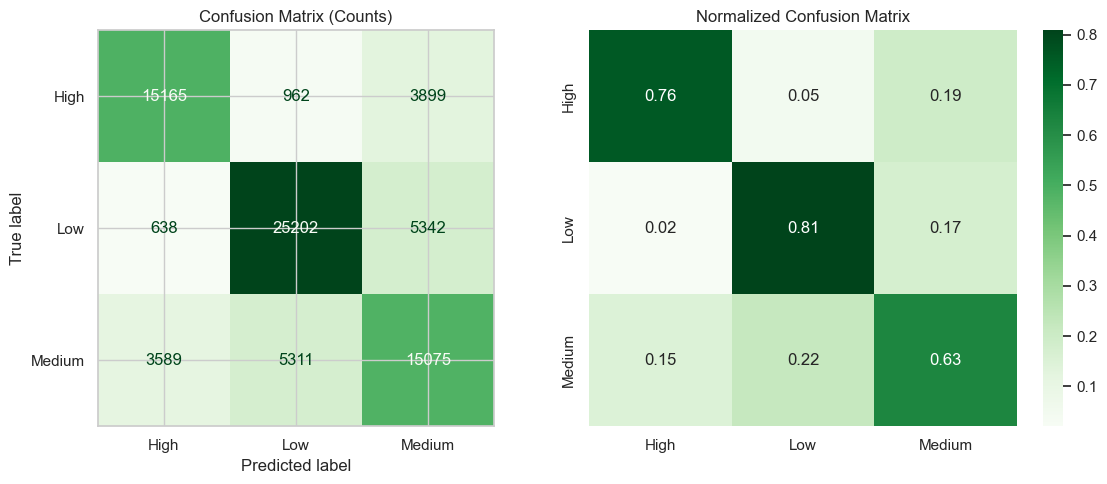

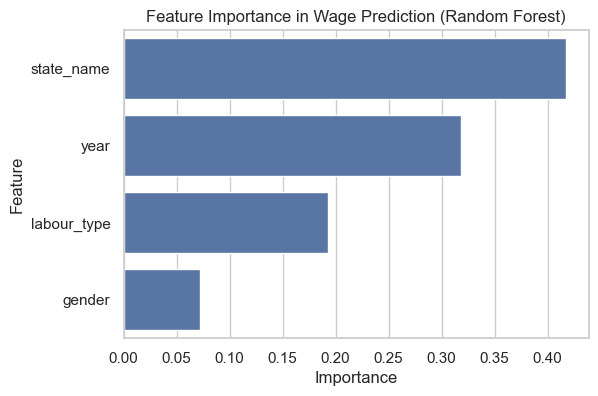

In [4]:
# 📦 Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, accuracy_score

# ✅ Step 1: Load data
df = pd.read_csv("cleaned_agri_wages.csv")
print("Dataset loaded. Shape:", df.shape)

# ✅ Step 2: Create wage category (Low, Medium, High)
low_thr, high_thr = np.percentile(df["monthly_average_wage"], [33.3, 66.6])

def wage_group(x):
    if x <= low_thr:
        return "Low"
    elif x <= high_thr:
        return "Medium"
    else:
        return "High"

df["wage_cat"] = df["monthly_average_wage"].apply(wage_group)
print(f"Wage thresholds — Low ≤ {low_thr:.2f}, Medium ≤ {high_thr:.2f}")

# ✅ Step 3: Select important features
features = ["gender", "labour_type", "state_name", "year"]
target = "wage_cat"

# Fill missing 'year' if present
if "year" not in df.columns and "month" in df.columns:
    df["year"] = pd.to_datetime(df["month"], errors="coerce").dt.year

df = df[features + [target]].dropna()

# ✅ Step 4: Encode categorical data
le_dict = {}
for col in features:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col].astype(str))
    le_dict[col] = le

y_le = LabelEncoder()
df[target] = y_le.fit_transform(df[target])

# ✅ Step 5: Train-Test Split
X = df[features]
y = df[target]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# ✅ Step 6: Feature Scaling (optional but improves performance)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# ✅ Step 7: Train Random Forest (optimized for accuracy)
rf = RandomForestClassifier(
    n_estimators=200,       # more trees = better accuracy
    max_depth=12,           # deeper trees capture more patterns
    min_samples_split=5,    # control overfitting
    min_samples_leaf=3,
    random_state=42,
    n_jobs=-1
)

rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)

# ✅ Step 8: Evaluate Model
acc = accuracy_score(y_test, y_pred)
print(f"\n🎯 Random Forest Accuracy: {acc*100:.2f}%\n")
print("Classification Report:")
print(classification_report(y_test, y_pred, target_names=y_le.classes_))

# ✅ Step 9: Confusion Matrix Visualization
cm = confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots(1, 2, figsize=(12, 5))
ConfusionMatrixDisplay(cm, display_labels=y_le.classes_).plot(ax=ax[0], cmap="Greens", colorbar=False)
ax[0].set_title("Confusion Matrix (Counts)")

cmn = cm.astype('float') / (cm.sum(axis=1)[:, np.newaxis] + 1e-9)
sns.heatmap(cmn, annot=True, fmt=".2f", cmap="Greens", xticklabels=y_le.classes_, yticklabels=y_le.classes_, ax=ax[1])
ax[1].set_title("Normalized Confusion Matrix")
plt.tight_layout()
plt.show()

# ✅ Step 10: Feature Importance
importances = pd.Series(rf.feature_importances_, index=features).sort_values(ascending=False)
plt.figure(figsize=(6,4))
sns.barplot(x=importances, y=importances.index)
plt.title("Feature Importance in Wage Prediction (Random Forest)")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.show()


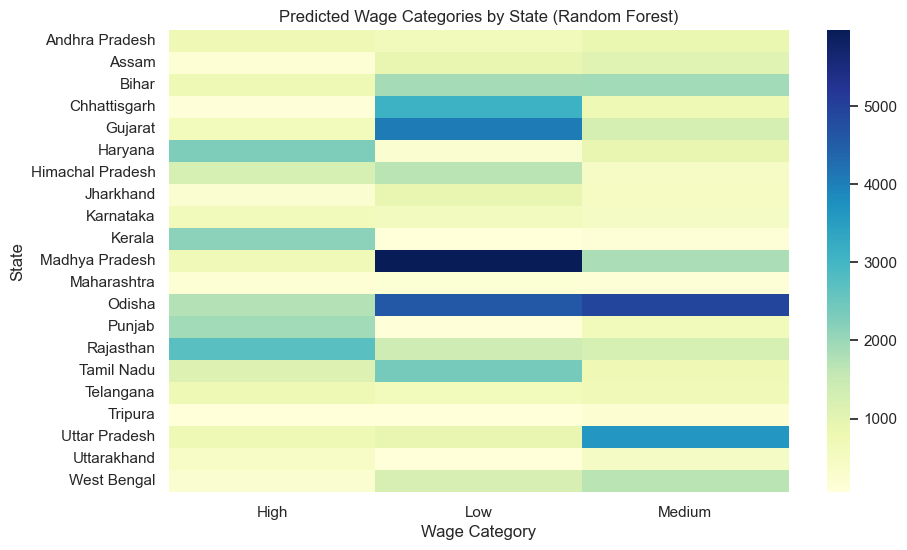

In [6]:
# y_pred contains predictions for the test split only (length = len(y_test)),
# so build the crosstab using the matching rows from the original df (y_test.index)
state_test = df.loc[y_test.index, "state_name"]

# If an encoder for state_name exists, convert back to original labels for display
try:
	le_state = encoders.get("state_name") if isinstance(encoders, dict) else None
	if le_state is not None:
		state_display = le_state.inverse_transform(state_test)
	else:
		state_display = state_test
except Exception:
	state_display = state_test

pred_labels = y_le.inverse_transform(y_pred)

state_wage_table = pd.crosstab(state_display, pred_labels)
plt.figure(figsize=(10,6))
sns.heatmap(state_wage_table, cmap="YlGnBu", annot=False)
plt.title("Predicted Wage Categories by State (Random Forest)")
plt.xlabel("Wage Category")
plt.ylabel("State")
plt.show()
